<a href="https://colab.research.google.com/github/Phrmth/New/blob/master/Resnet18_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import packages 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import tensor
from torch import nn
import torch.nn.functional as F
import torch
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

In [0]:

if torch.cuda.is_available():
 device = torch.device("cuda")
else : device = torch.device("cpu")

# Hyper-parameters 
num_epochs = 20
batch_size = 64
learning_rate = 0.001

# Image preprocessing modules
# tfs = transforms.Compose([
                          
#     transforms.ToPILImage(),
#     transforms.Pad(4),
#     transforms.Resize(224,224),
#     # transforms.Grayscale(num_output_channels=3), # for 3 channel image
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(32),
#     transforms.ToTensor()])

# tfs = transforms.Compose([
#                           # transforms.ToPILImage(),
#                           transforms.Resize((224,224)),
                          
#                           # transforms.RandomHorizontalFlip(),
#                           # transforms.RandomPerspective(),
#                           transforms.ToTensor(), 
#                           # transforms.Normalize([0.5], [0.5])
#                           ])


train_transforms = transforms.Compose(
    [
    #  transforms.ToPILImage(),
     transforms.Resize((224,224)),
     transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2)),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5,), std=(0.5,))])

val_test_transforms = transforms.Compose(
    [
    #  transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5,), std=(0.5,))])

In [0]:
# Data
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform = transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform = transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size*2, 
                                          shuffle=False)

In [0]:
x,_= next(iter(train_loader))

In [72]:
x.shape

torch.Size([64, 1, 224, 224])

In [0]:
x[0]

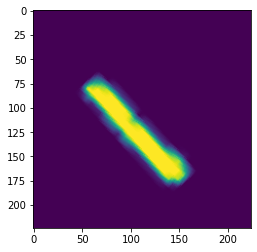

In [73]:
plt.imshow(x[0].view(224,224))

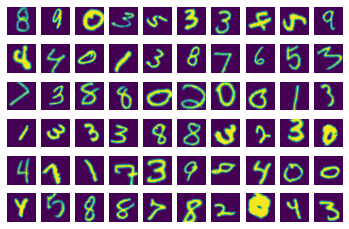

In [30]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(x[index].numpy().squeeze())

In [0]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv(nf,nf)
        self.conv2 = conv(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

res_block = ResBlock

# Refactoring - Conv layer, BatchNorm and ReLU sequence 
def conv(ni,nf, stride = 1): return nn.Sequential(nn.Conv2d(ni, nf, kernel_size=3, stride=stride , padding=1), 
                                      nn.ReLU(),
                                      nn.BatchNorm2d(nf)
                                       
                                       )
def conv_and_res(ni,nf): return nn.Sequential(conv(ni, nf, stride = 2), res_block(nf))


model = nn.Sequential(
    conv_and_res(1, 8), #14
    conv_and_res(8, 16),  #7
    conv_and_res(16, 32),  # 4
    conv_and_res(32, 16), # 2
    conv(16, 10, stride = 2),    #1
    nn.Flatten()
)

In [0]:
model

In [75]:
from torchvision import models
from torchsummary import summary

summary(resnet18.cuda(), (1,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [0]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss().to(device)
opt = torch.optim.Adam(resnet18.parameters(), lr=learning_rate)

In [0]:
# Model fit - Train and validation scores per epoch !
train_loss = []
valid_loss = []
ep, learnrate , err , err_v = [],[],[],[]

def fit(epochs, model , train_loader, test_loader, opt, loss_func ):
  
  model.to(device)
  curr_lr = learning_rate
  for epoch in range(epochs):
    
    for i,(xb, yb) in enumerate(train_loader):
      # print(xb.shape)
      model.train()
      opt.zero_grad()
      xb,yb = xb.to(device),yb.to(device)

      pred = model(xb)
      loss = loss_func(pred,yb)
      loss.backward()
      opt.step()

    train_loss.append(loss)
      # with torch.no_grad():
      #   for p in model.parameters(): p-= p.grad * lr

    with torch.no_grad():
      for xv,yv in test_loader:
        
        xv,yv = xv.to(device),yv.to(device)
        pred = model(xv)
        loss_v = loss_func(pred,yv)
        ep = ((torch.argmax(pred,dim = 1) == yv).sum().item())/yv.size(0)
      valid_loss.append(loss_v)


        # Decay learning rate
    if (epoch+1) % 3 == 0:
      curr_lr /= 2
      update_lr(opt, curr_lr)

    
    if (epoch+1) % 1 == 0: 
      print(f"Epoch{epoch} : Train Loss {loss.item()} , Valid Loss {loss_v.item()}. Accuracy {ep}")
  
  return train_loss, valid_loss


In [0]:
# Training and Validation Loss 
%time train_loss, valid_loss = fit(10, model, train_loader, test_loader, opt, loss_fn)

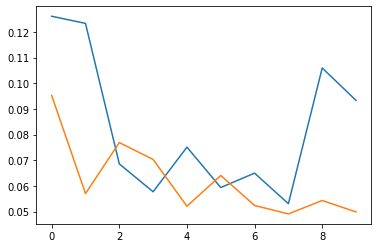

In [103]:
plt.plot(ep, err)
plt.plot(ep, err_v)


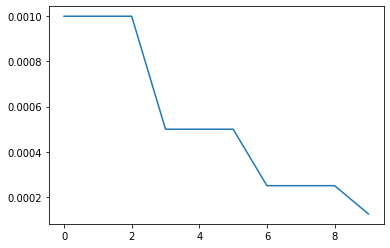

In [104]:
plt.plot(ep, learnrate)

In [0]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [90]:
# Final testing on validation data of 10000 samples. 
with torch.no_grad():
  correct = 0
  total = 0
  resnet18 = resnet18.to(device)
  # print(model)
  for xv,yv in test_loader:
    xv,yv = xv.to(device),yv.to(device)
    pred = resnet18(xv)
    # print(pred)
    # _, predicted = torch.max(pred.data, 1)
    total += yv.size(0)
    # print("correct per batch",(torch.argmax(pred,dim = 1) == yv).sum())
    correct += (torch.argmax(pred,dim = 1) == yv).sum()
    # print(f"Accuracy per batch is {((torch.argmax(pred,dim = 1) == yv).sum().item())/yv.size(0)}")
  print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))


Accuracy of the network on the 10000 test images: 99 %


In [0]:
from torchvision import models
resnet18 = models.resnet18()

In [0]:
resnet18

In [0]:
resnet18.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet18.fc = nn.Linear(512,10)

In [89]:
%time train_loss, valid_loss = fit(7, resnet18, train_loader, test_loader, opt, loss_fn)

Epoch0 : Train Loss 0.08438676595687866 , Valid Loss 0.003984034061431885. Accuracy 1.0
Epoch1 : Train Loss 0.06326629966497421 , Valid Loss 0.0004735589027404785. Accuracy 1.0
Epoch2 : Train Loss 0.03358492627739906 , Valid Loss 0.005784392356872559. Accuracy 1.0
Epoch3 : Train Loss 0.008832022547721863 , Valid Loss 8.32676887512207e-05. Accuracy 1.0
Epoch4 : Train Loss 0.08781704306602478 , Valid Loss 0.000250011682510376. Accuracy 1.0
Epoch5 : Train Loss 0.13686485588550568 , Valid Loss 0.0009900331497192383. Accuracy 1.0
Epoch6 : Train Loss 0.00022929906845092773 , Valid Loss 9.834766387939453e-06. Accuracy 1.0
CPU times: user 2min 3s, sys: 3.84 s, total: 2min 6s
Wall time: 2min 7s


In [0]:
import math
def find_lr(model, loss_fn, optimizer, init_value=1e-8, final_value=10.0):
  number_in_epoch = len(train_loader) - 1
  update_step = (final_value / init_value) ** (1 / number_in_epoch)
  lr = init_value
  optimizer.param_groups[0]["lr"] = lr
  best_loss = 0.0
  batch_num = 0
  losses = []
  log_lrs = []
  model = model.to(device)
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    batch_num += 1
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
  # Crash out if loss explodes
    # if batch_num > 1 and loss > 4 * best_loss:
    #   print("here")
    #   return log_lrs[10:-5], losses[10:-5]
    # Record the best loss
    if loss < best_loss or batch_num == 1:
      best_loss = loss
      # Store the values
      losses.append(loss)
      log_lrs.append(math.log10(lr))
      # Do the backward pass and optimize
      loss.backward()
      optimizer.step()
    # Update the lr for the next step and store
      lr *= update_step
      optimizer.param_groups[0]["lr"] = lr
  return log_lrs[10:-5], losses[10:-5]

In [47]:
logs

[]

In [0]:
logs,losses = find_lr(resnet18, loss_fn, opt)
plt.plot(logs,losses)
